<a href="https://colab.research.google.com/github/jinmedi/MT_project/blob/main/MP_project240728.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


내시경 이미지 부분만 크롭

In [ ]:
import cv2
import numpy as np
import os

def detect_and_crop_color_image(image_path, padding=10):
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to read image at {image_path}")
        return None

    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define range for high saturation colors
    lower_sat = np.array([0, 50, 50])
    upper_sat = np.array([179, 255, 255])

    # Threshold the HSV image to get only high saturation colors
    mask = cv2.inRange(hsv, lower_sat, upper_sat)

    # Perform morphological operations to remove noise
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print(f"Warning: No color regions found in {image_path}")
        return None

    # Find the largest contour (which should be our color image)
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding rectangle of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Add padding
    x = max(0, x - padding)
    y = max(0, y - padding)
    w = min(img.shape[1] - x, w + 2*padding)
    h = min(img.shape[0] - y, h + 2*padding)

    # Crop the image
    cropped = img[y:y+h, x:x+w]

    return cropped

def crop_images_in_folder(input_folder, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        img_path = os.path.join(input_folder, filename)
        if os.path.isfile(img_path):
            cropped_image = detect_and_crop_color_image(img_path)
            if cropped_image is not None:
                output_path = os.path.join(output_folder, filename)
                cv2.imwrite(output_path, cropped_image)
                print(f"Processed and saved: {filename}")
            else:
                print(f"Failed to process: {filename}")

# Example usage:
input_folder = '/content/drive/MyDrive/Colab Notebooks/MT_project/MT_0'
output_folder = '/content/drive/MyDrive/Colab Notebooks/MT_project/MT_0_crop'
crop_images_in_folder(input_folder, output_folder)

Processed and saved: c0_22_81bddd1d.jpg
Processed and saved: c0_2_0d1ebf6c.jpg
Processed and saved: c0_2_b9bd9ee4.jpg
Processed and saved: c0_25_81bddd1d.jpg
Processed and saved: c0_11_81bddd1d.jpg
Processed and saved: c0_2_c318f4f9.jpg
Processed and saved: c0_18_81bddd1d.jpg
Processed and saved: c0_2_487cae5b.jpg
Processed and saved: c0_16_81bddd1d.jpg
Processed and saved: c0_13_81bddd1d.jpg
Processed and saved: c0_17_81bddd1d.jpg
Processed and saved: c0_2_3644aa4c.jpg
Processed and saved: c0_32_81bddd1d.jpg
Processed and saved: c0_33_81bddd1d.jpg
Processed and saved: c0_2_7317a4b5.jpg
Processed and saved: c0_2_8bc95ee5.jpg
Processed and saved: c0_2_f7db44d2.jpg
Processed and saved: c0_27_81bddd1d.jpg
Processed and saved: c0_30_81bddd1d.jpg
Processed and saved: c0_31_81bddd1d.jpg


'/content/drive/MyDrive/Colab Notebooks/MT_project/MT_0_crop에 class '0'에 해당하는 이미지데이터 2093개와
'/content/drive/MyDrive/Colab Notebooks/MT_project/MT_1_crop'에 class '1'에 해당하는이미지데이터 2839개가 준비되어 있음.

각각의 폴더에서 랜덤으로 200장씩을 추려서 val 및 test를 위한 데이터셋을 만들어주는 코드를 작성해.
'/content/drive/MyDrive/Colab Notebooks/MT_240721/val/MT_0'
'/content/drive/MyDrive/Colab Notebooks/MT_240721/val/MT_1'
'/content/drive/MyDrive/Colab Notebooks/MT_240721/test/MT_0'
'/content/drive/MyDrive/Colab Notebooks/MT_240721/test/MT_1'
에 각각 200장씩을 담고, 나머지 데이터는
'/content/drive/MyDrive/Colab Notebooks/MT_240721/train/MT_0'
'/content/drive/MyDrive/Colab Notebooks/MT_240721/train/MT_1'

In [ ]:
import os
import shutil
import random
import glob

# 폴더 경로 설정
source_folders = {
    '0': '/content/drive/MyDrive/Colab Notebooks/MT_project/MT_0_crop',
    '1': '/content/drive/MyDrive/Colab Notebooks/MT_project/MT_1_crop'
}

destination_folders = {
    'val': {
        '0': '/content/drive/MyDrive/Colab Notebooks/MT_240721/val/MT_0',
        '1': '/content/drive/MyDrive/Colab Notebooks/MT_240721/val/MT_1'
    },
    'test': {
        '0': '/content/drive/MyDrive/Colab Notebooks/MT_240721/test/MT_0',
        '1': '/content/drive/MyDrive/Colab Notebooks/MT_240721/test/MT_1'
    },
    'train': {
        '0': '/content/drive/MyDrive/Colab Notebooks/MT_240721/train/MT_0',
        '1': '/content/drive/MyDrive/Colab Notebooks/MT_240721/train/MT_1'
    }
}

# 디렉토리 생성 함수
def create_dir_if_not_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

# 데이터 이동 함수
def move_images(source_folder, dest_folder, num_images):
    images = glob.glob(os.path.join(source_folder, '*'))
    selected_images = random.sample(images, num_images)
    for image in selected_images:
        shutil.move(image, dest_folder)

# 메인 작업
for class_label in ['0', '1']:
    source_folder = source_folders[class_label]

    # 디렉토리 생성
    for folder_type in ['val', 'test', 'train']:
        create_dir_if_not_exists(destination_folders[folder_type][class_label])

    # validation과 test 이미지를 각각 200장씩 추출 및 이동
    val_folder = destination_folders['val'][class_label]
    test_folder = destination_folders['test'][class_label]
    move_images(source_folder, val_folder, 200)
    move_images(source_folder, test_folder, 200)

    # 나머지 이미지를 train 폴더로 이동
    remaining_images = glob.glob(os.path.join(source_folder, '*'))
    for image in remaining_images:
        shutil.move(image, destination_folders['train'][class_label])

print("이미지 데이터 분할이 완료되었습니다.")


이미지 데이터 분할이 완료되었습니다.


수평 뒤집기와 90도, 180도, 270도 회전만 허용하도록 코드를 수정

In [ ]:
import tensorflow as tf
import numpy as np
import os

# 증강할 이미지 수
augmented_image_count = 6772

# 원본 이미지 폴더
train_folders = {
    '0': '/content/drive/MyDrive/Colab Notebooks/MT_240721/train_unaug/0',
    '1': '/content/drive/MyDrive/Colab Notebooks/MT_240721/train_unaug/1'
}

# 증강된 이미지를 저장할 폴더
aug_folders = {
    '0': '/content/drive/MyDrive/Colab Notebooks/MT_240721/train_new/0',
    '1': '/content/drive/MyDrive/Colab Notebooks/MT_240721/train_new/1'
}

# 디렉토리 생성 함수
def create_dir_if_not_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

# 디렉토리 생성
for class_label in ['0', '1']:
    create_dir_if_not_exists(aug_folders[class_label])

# 90도, 180도, 270도 회전 함수
def rotate_image(image):
    angle = np.random.choice([90, 180, 270])
    return tf.image.rot90(image, k=angle // 90)

# 수평 뒤집기 함수
def flip_image(image):
    return tf.image.flip_left_right(image)

# 증강 및 저장 함수
def augment_images(source_folder, dest_folder, target_count):
    images = os.listdir(source_folder)
    image_count = len(images)
    aug_factor = (target_count // image_count) + 1

    for img_name in images:
        img_path = os.path.join(source_folder, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path)
        x = tf.keras.preprocessing.image.img_to_array(img)

        for i in range(aug_factor):
            # 원본 이미지
            augmented = x

            # 회전 적용 (50% 확률)
            if np.random.rand() < 0.5:
                augmented = rotate_image(augmented)

            # 수평 뒤집기 적용 (50% 확률)
            if np.random.rand() < 0.5:
                augmented = flip_image(augmented)

            # 증강된 이미지 저장
            tf.keras.preprocessing.image.save_img(
                os.path.join(dest_folder, f'aug_{i}_{img_name}'),
                augmented
            )

# 각 클래스에 대해 증강 수행
for class_label in ['0', '1']:
    source_folder = train_folders[class_label]
    dest_folder = aug_folders[class_label]
    augment_images(source_folder, dest_folder, augmented_image_count)

print("데이터 증강이 완료되었습니다.")

데이터 증강이 완료되었습니다.


'0':'/content/drive/MyDrive/Colab Notebooks/MT_240721/train/MT_0'에는 1693개의 이미지가 들어 있고,
'1': '/content/drive/MyDrive/Colab Notebooks/MT_240721/train/MT_1'에는 2439개의 이미지가 들어 있음.

data augmentation을 해서,
'0':'/content/drive/MyDrive/Colab Notebooks/MT_240721/train/MT_0_aug'폴더와
'1': '/content/drive/MyDrive/Colab Notebooks/MT_240721/train/MT_1_uag'폴더에 각각 6772장의 학습용 데이터를 만들어주는 코드

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil

# 증강할 이미지 수
augmented_image_count = 6772

# 원본 이미지 폴더
train_folders = {
    '0': '/content/drive/MyDrive/Colab Notebooks/MT_240721/train/MT_0',
    '1': '/content/drive/MyDrive/Colab Notebooks/MT_240721/train/MT_1'
}

# 증강된 이미지를 저장할 폴더
aug_folders = {
    '0': '/content/drive/MyDrive/Colab Notebooks/MT_240721/train/MT_0_aug',
    '1': '/content/drive/MyDrive/Colab Notebooks/MT_240721/train/MT_1_aug'
}

# 디렉토리 생성 함수
def create_dir_if_not_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

# 디렉토리 생성
for class_label in ['0', '1']:
    create_dir_if_not_exists(aug_folders[class_label])

# 이미지 증강 설정
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 증강 및 저장 함수
def augment_images(source_folder, dest_folder, target_count):
    images = os.listdir(source_folder)
    image_count = len(images)
    aug_factor = (target_count // image_count) + 1

    for img_name in images:
        img_path = os.path.join(source_folder, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path)
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = x.reshape((1,) + x.shape)

        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=dest_folder, save_prefix='aug', save_format='jpeg'):
            i += 1
            if i >= aug_factor:
                break

# 각 클래스에 대해 증강 수행
for class_label in ['0', '1']:
    source_folder = train_folders[class_label]
    dest_folder = aug_folders[class_label]
    augment_images(source_folder, dest_folder, augmented_image_count)

print("데이터 증강이 완료되었습니다.")


2024.7.28일 작업 시작

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 경로 설정
train_data_dir = '/content/drive/MyDrive/Colab Notebooks/MT_240721/train_unaug'
val_data_dir = '/content/drive/MyDrive/Colab Notebooks/MT_240721/val'
test_data_dir = '/content/drive/MyDrive/Colab Notebooks/MT_240721/test'

# 이미지 크기 및 배치 크기 설정
img_width, img_height = 224, 224
batch_size = 32

# 데이터 증강 및 전처리 (훈련 세트에만 적용)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# 검증 및 테스트 세트에는 증강을 적용하지 않고 스케일링만 수행
val_test_datagen = ImageDataGenerator(rescale=1./255)

# 훈련 데이터 생성기
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

# 검증 데이터 생성기
validation_generator = val_test_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

# 테스트 데이터 생성기
test_generator = val_test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # 테스트 세트는 셔플하지 않음
)

# 클래스 가중치 계산 (훈련 세트 기준)
total_samples = 1693 + 2439
weight_for_0 = (1 / 1693) * (total_samples / 2.0)
weight_for_1 = (1 / 2439) * (total_samples / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

# MobileNetV2 모델 로드 (weights='imagenet'으로 사전 학습된 가중치 사용)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# 새로운 분류기 레이어 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# 최종 모델 생성
model = Model(inputs=base_model.input, outputs=output)

# 기본 모델의 레이어들을 고정 (선택적)
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
epochs = 20
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    class_weight=class_weight
)

# 모델 저장
model.save('mobilenetv2_model.h5')

# 테스트 세트에 대한 평가
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# 학습 결과 출력
print(history.history)

Found 4132 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
9406464/9406464 [==============================] - 2s 0us/step
Epoch 1/20
129/129 [==============================] - 2109s 16s/step - loss: 0.6362 - accuracy: 0.6266 - val_loss: 0.5775 - val_accuracy: 0.6875
Epoch 2/20
129/129 [==============================] - 73s 567ms/step - loss: 0.5665 - accuracy: 0.6971 - val_loss: 0.5816 - val_accuracy: 0.6979
Epoch 3/20
129/129 [==============================] - 74s 572ms/step - loss: 0.5520 - accuracy: 0.7090 - val_loss: 0.5230 - val_accuracy: 0.7188
Epoch 4/20
129/129 [==============================] - 74s 572ms/step - loss: 0.5418 - accuracy: 0.7241 - val_loss: 0.5276 - val_accuracy: 0.7344
Epoch 5/20
129/129 [==============================] - 74s 572ms/step - loss: 0.5283 - accuracy: 0.7339 - val_loss: 0.5409 - val_accuracy: 0.7266
Epoch 6/20
129/129 [==============================] - 74s 570ms/step - loss: 0.5098 - ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 247s 22s/step - loss: 0.4828 - accuracy: 0.7448
Test accuracy: 0.7448
Test loss: 0.4828
{'loss': [0.6361958384513855, 0.5665102601051331, 0.5520390272140503, 0.5418499708175659, 0.5283254981040955, 0.5097712874412537, 0.4984736442565918, 0.4979851245880127, 0.4820324778556824, 0.4771963655948639, 0.47055646777153015, 0.4844398498535156, 0.4568382799625397, 0.4598428010940552, 0.44637489318847656, 0.4331839084625244, 0.43571051955223083, 0.4271153211593628, 0.4213307201862335, 0.41754719614982605], 'accuracy': [0.6265853643417358, 0.6970731616020203, 0.7090243697166443, 0.7241463661193848, 0.7339024543762207, 0.7392683029174805, 0.754878044128418, 0.7514634132385254, 0.7634146213531494, 0.77170729637146, 0.7629268169403076, 0.7578048706054688, 0.7821951508522034, 0.7758536338806152, 0.7858536839485168, 0.7960975766181946, 0.7948780655860901, 0.8002439141273499, 0.8034146428108215, 0.8039024472236633], 'val_loss': [0.5774917006492615, 0.5816199779

데이터 증강 강화:

rotation_range를 40으로 증가
shear_range, zoom_range, vertical_flip, brightness_range 추가


모델 아키텍처 조정:

더 복잡한 분류기 헤드 추가 (두 개의 Dense 레이어와 Dropout 레이어)
기본 모델의 마지막 30개 레이어를 fine-tuning을 위해 훈련 가능하도록 설정


학습 과정 최적화:

에폭 수를 50으로 증가
ReduceLROnPlateau 콜백 추가하여 학습률을 동적으로 조정

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 데이터 경로 설정
train_data_dir = '/content/drive/MyDrive/Colab Notebooks/MT_240721/train_unaug'
val_data_dir = '/content/drive/MyDrive/Colab Notebooks/MT_240721/val'
test_data_dir = '/content/drive/MyDrive/Colab Notebooks/MT_240721/test'

# 이미지 크기 및 배치 크기 설정
img_width, img_height = 224, 224
batch_size = 32

# 데이터 증강 및 전처리 (강화된 버전)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.2]
)

# 검증 및 테스트 세트에는 증강을 적용하지 않고 스케일링만 수행
val_test_datagen = ImageDataGenerator(rescale=1./255)

# 데이터 생성기
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# 클래스 가중치 계산
total_samples = 1693 + 2439
weight_for_0 = (1 / 1693) * (total_samples / 2.0)
weight_for_1 = (1 / 2439) * (total_samples / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

# MobileNetV2 모델 로드
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# 새로운 분류기 레이어 추가 (더 복잡한 구조)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

# 최종 모델 생성
model = Model(inputs=base_model.input, outputs=output)

# Fine-tuning을 위해 기본 모델의 일부 레이어 해제
for layer in base_model.layers[-30:]:
    layer.trainable = True

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# 콜백 설정
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# 모델 학습
epochs = 50  # 에폭 수 증가
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    class_weight=class_weight,
    callbacks=[reduce_lr]
)

# 모델 저장
model.save('240728_2_mobilenetv2_model.h5')

# 테스트 세트에 대한 평가
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# 학습 결과 출력
print(history.history)

Found 4132 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
9406464/9406464 [==============================] - 2s 0us/step
Epoch 1/50
129/129 [==============================] - 2009s 15s/step - loss: 0.6505 - accuracy: 0.6300 - val_loss: 0.8523 - val_accuracy: 0.5286 - lr: 1.0000e-04
Epoch 2/50
129/129 [==============================] - 82s 635ms/step - loss: 0.5421 - accuracy: 0.7220 - val_loss: 1.4656 - val_accuracy: 0.5130 - lr: 1.0000e-04
Epoch 3/50
129/129 [==============================] - 82s 636ms/step - loss: 0.5022 - accuracy: 0.7571 - val_loss: 1.3867 - val_accuracy: 0.5365 - lr: 1.0000e-04
Epoch 4/50
129/129 [==============================] - 82s 637ms/step - loss: 0.4597 - accuracy: 0.7902 - val_loss: 1.2025 - val_accuracy: 0.5859 - lr: 1.0000e-04
Epoch 5/50
129/129 [==============================] - 82s 635ms/step - loss: 0.4325 - accuracy: 0.7993 - val_loss: 1.1174 - val_accuracy: 0.6068 - lr: 1.0000e-04
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 258s 23s/step - loss: 0.6211 - accuracy: 0.8151
Test accuracy: 0.8151
Test loss: 0.6211
{'loss': [0.6505040526390076, 0.54213947057724, 0.5021506547927856, 0.45973750948905945, 0.432546466588974, 0.4124104082584381, 0.4022182524204254, 0.38112887740135193, 0.36604273319244385, 0.3425300121307373, 0.32046979665756226, 0.3159937262535095, 0.30159875750541687, 0.2779621481895447, 0.26576587557792664, 0.25539615750312805, 0.2640213668346405, 0.22509711980819702, 0.23783621191978455, 0.2383202761411667, 0.21834692358970642, 0.20131468772888184, 0.18315666913986206, 0.15772172808647156, 0.16354422271251678, 0.13078758120536804, 0.13810929656028748, 0.1335221230983734, 0.1289195865392685, 0.13473553955554962, 0.12931279838085175, 0.1285160630941391, 0.12478435039520264, 0.12782485783100128, 0.11856811493635178, 0.12338823825120926, 0.11679816991090775, 0.11720675230026245, 0.1258583664894104, 0.13155169785022736, 0.11409486085176468, 0.1175982952117919

In [2]:
# 테스트 세트에 대한 평가
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Confusion Matrix 생성을 위한 예측
test_generator.reset()
y_pred = model.predict(test_generator, steps=test_generator.samples // batch_size)
y_pred = (y_pred > 0.5).astype(int)  # 이진 분류에서 임계값 0.5 적용

# 실제 레이블 가져오기
y_true = test_generator.classes

# Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred)

# Confusion Matrix 시각화
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Class 0', 'Class 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted label')
plt.ylabel('True label')

# 각 셀에 숫자 표시
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# 분류 보고서 출력
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# 학습 결과 출력
print(history.history)

12/12 [==============================] - 3s 240ms/step - loss: 0.6211 - accuracy: 0.8151
Test accuracy: 0.8151
Test loss: 0.6211
12/12 [==============================] - 4s 250ms/step


NameError: name 'confusion_matrix' is not defined

2024.7.28  work end

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GaussianNoise, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras import backend as K

# 사용자 정의 F1 Score 메트릭 정의
def f1_score(y_true, y_pred):
    precision = tf.keras.metrics.Precision()(y_true, y_pred)
    recall = tf.keras.metrics.Recall()(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# 폴더 경로 설정
train_set = '/content/drive/MyDrive/Colab Notebooks/MT_240721/train_new'
val_set = '/content/drive/MyDrive/Colab Notebooks/MT_240721/val'
test_set = '/content/drive/MyDrive/Colab Notebooks/MT_240721/test'

# 데이터 정규화
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# ... (rest of your code)

# 데이터 생성기 설정
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'  # Change to 'binary' for 2 classes
)

validation_generator = validation_datagen.flow_from_directory(
    val_set,
    target_size=(224, 224),
    batch_size=16,
    shuffle=True,
    class_mode='binary'  # Change to 'binary' for 2 classes
)

test_generator = test_datagen.flow_from_directory(
    test_set,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'  # Change to 'binary' for 2 classes
)


# 모델 정의
base_model = tf.keras.applications.EfficientNetB3(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.35))
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.35))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

# 모델 컴파일
optimizer = Adam(learning_rate=0.01)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',  # Use binary_crossentropy for binary classification
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)


# 모델 학습
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)


Found 15782 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
43941136/43941136 [==============================] - 3s 0us/step
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 7, 7, 1536)        10783535  
 )                                                               
                                                                 
 gaussian_noise_28 (Gaussia  (None, 7, 7, 1536)        0         
 nNoise)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
 4 (GlobalAveragePooling2D)                                      
                                                                 
 dense_28 (Dense)            (None, 256)               393472


##Model evaluation

In [ ]:
model.evaluate(train_generator)

987/987 [==============================] - 108s 109ms/step - loss: 0.6941 - accuracy: 0.4831 - precision: 0.4700 - recall: 0.9013 - auc: 0.5386


[0.6941485404968262,
 0.48308199644088745,
 0.47003063559532166,
 0.9013257026672363,
 0.5386248826980591]

In [ ]:
model.evaluate(validation_generator)

25/25 [==============================] - 3s 137ms/step - loss: 0.6932 - accuracy: 0.4975 - precision: 0.4986 - recall: 0.8900 - auc: 0.5256


[0.6931976079940796,
 0.4975000023841858,
 0.49859943985939026,
 0.8899999856948853,
 0.5256375074386597]

In [ ]:
model.evaluate(test_generator)

25/25 [==============================] - 3s 133ms/step - loss: 0.6918 - accuracy: 0.4975 - precision: 0.4986 - recall: 0.9100 - auc: 0.5751


[0.6917821764945984,
 0.4975000023841858,
 0.4986301362514496,
 0.9100000262260437,
 0.5751124620437622]

**Performance Plots**

**Learning curve**

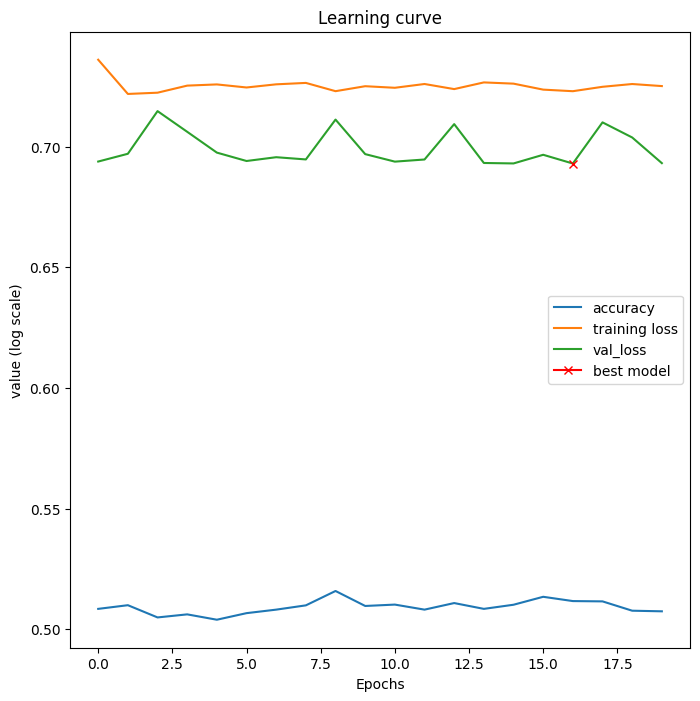

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend()

**Precision plot**

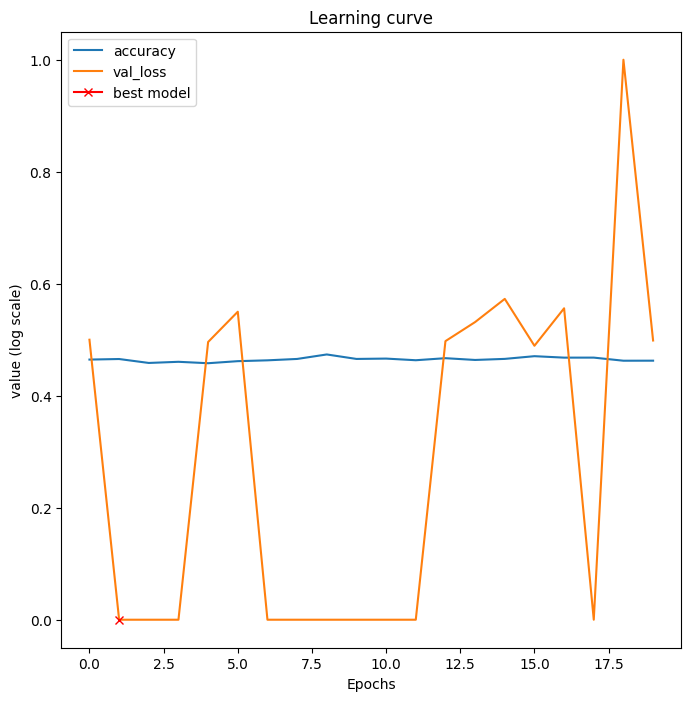

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["precision"], label="accuracy")
plt.plot(history.history["val_precision"], label="val_loss")
plt.plot( np.argmin(history.history["val_precision"]), np.min(history.history["val_precision"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

**Recall plot**

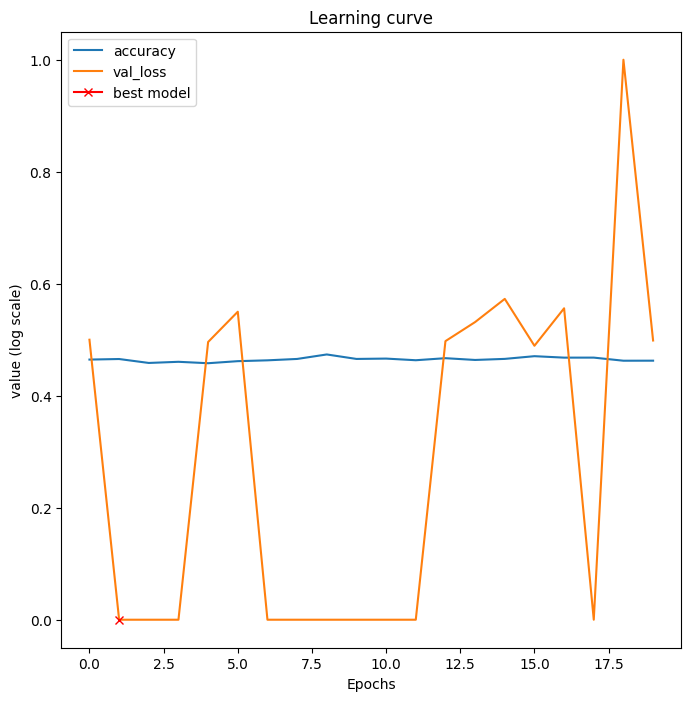

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["precision"], label="accuracy")
plt.plot(history.history["val_precision"], label="val_loss")
plt.plot( np.argmin(history.history["val_precision"]), np.min(history.history["val_precision"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

**AUC plot**

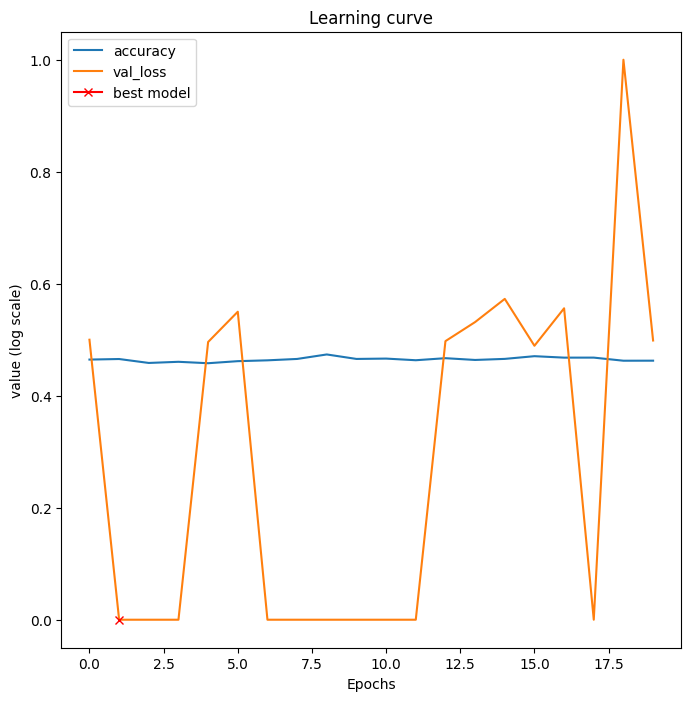

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["precision"], label="accuracy")
plt.plot(history.history["val_precision"], label="val_loss")
plt.plot( np.argmin(history.history["val_precision"]), np.min(history.history["val_precision"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

# Model prediction


In [ ]:
from keras.preprocessing import image
img = image.load_img('../input/curated-colon-dataset-for-deep-learning/test/0_normal/test_normal_ (1).jpg',target_size=(224,224))
imag = image.img_to_array(img)
imaga = np.expand_dims(imag,axis=0)
ypred = model.predict(imaga)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
    op="malignancy"
elif a==1:
    op="Benign"


plt.imshow(img)
print("THE UPLOADED IMAGE SEEMS TO BE: "+str(op))


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/MT_project/my_model240719.h5')

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/MT_project/my_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('my_model.keras')